In [1]:
using Gridap, Gridap.Geometry, Gridap.Fields
using Gmsh, GridapGmsh
using GLMakie, DelimitedFiles, Interpolations
using LinearAlgebra, SparseArrays, KrylovKit
using ChainRulesCore, Zygote
using PartitionedArrays
using NLopt
using GridapMakie

import Gridap.CellData: Interpolable
import ChainRulesCore: rrule
import Gmsh: gmsh


main_path = "/Users/jayyao/Documents/Research/RamanInFluid/"
include(main_path*"Materials/Materials.jl")
include(main_path*"Module/Mesh_Periodic.jl")
include(main_path*"Module/Helper.jl")
include(main_path*"Module/GridapFE.jl")
include(main_path*"Module/Control.jl")
include(main_path*"Module/Model.jl")
include(main_path*"Module/Objective.jl")
include(main_path*"Module/Objective_emission.jl")

ge_p_optimize (generic function with 3 methods)

In [2]:
material = "Ag"
n_λ, k_λ = RefractiveIndex(material,main_path,true)
λ1 = 532
λ2 = 549
nm1 = n_λ(λ1) + 1im * k_λ(λ1)
nm2 = n_λ(λ2) + 1im * k_λ(λ2)
nf = sqrt(1.77)
μ = 1
R = 1e-10
nm1,nm2

(0.054007220216606505 + 3.42898916967509im, 0.05988059701492538 + 3.5892477611940294im)

In [3]:
hr = (λ1+λ2)/nf/4          # Height of Raman molecule
# Geometry parameters of the mesh
L = 150           # Length of the normal region
hair = 500 + hr       # Height of the air region
hs = 300 + hr         # Height of the source location in air
ht = 200 + hr         # Height of the target location in air
hd = 200          # Height of design domain
hsub = 100        # Height of substrate domain below design domain
dpml = 300        # Thickness of the PML
hrd = (hd, hr)
# Characteristic length (controls the resolution, smaller the finer)
# resol = 30        # Number of points per wavelength
l1 = 20      # Air
l2 = 1       # Design domain
l3 = l1           # PML

meshfile = "geometry.msh"
geo_param = PeriodicGeometry(L, hair, hs, ht, hd, hsub, dpml, l1, l2, l3)
MeshGenerator(geo_param, meshfile)

LHp=(Inf, hair + hd)  # Start of PML for x,y > 0
LHn=(Inf, hsub)       # Start of PML for x,y < 0


ω1 = 2 * π / λ1
phys1 = PhysicalParameters(ω1, nf, nm1, nm1, μ, R, dpml, LHp, LHn, hd)
ω2 = 2 * π / λ2
phys2 = PhysicalParameters(ω2, nf, nm2, nm2, μ, R, dpml, LHp, LHn, hd)
# run(`scp wyao@txe1-login.mit.edu:/home/gridsan/wyao/Research/RamanInFluid/cloud/task1/geometry.msh /Users/jayyao/Documents/Research/RamanInFluid/`)

Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Meshing curve 18 (Line)
Info    : Meshing curve 19 (L

PhysicalParameters(0.011444781980290685, 1.3304134695650072, 0.05988059701492538 + 3.5892477611940294im, 0.05988059701492538 + 3.5892477611940294im, 1.0, 1.0e-10, 300.0, (Inf, 903.1323390677645), (Inf, 100.0), 200.0)

In [17]:
############  Optimization parameters #############
flag_f = true       # Turn on filter
flag_t = true       # Turn on threshold

# Filter and threshold paramters
r = (5, 5)  # Filter radius
β = 32.0                  # β∈[1,∞], threshold sharpness
η = 0.5                   # η∈[0,1], threshold center

α = 1.0 / (2 * 1000.0)    # Equivalent loss α = 1/2Q

# Number of subspace
K = 20

# Amplify g for NLopt
Amp = 1e-3

# Sum over kx
nkx = 30
nparts = nkx / 2

Bp = true          # Matrix B depend on parameters?
pv = 1

# Foundary constraint parameters
c = 0*(r[1])^4
lw = r[1]
ls = r[1]
ηe = fηe(lw / r[1])
ηd = fηd(lw / r[1])

control = ControllingParameters(flag_f, flag_t, r, β, η, α, nparts, nkx, K, Amp, Bp, pv, c, ηe, ηd, hrd)

gridap = GridapFE(meshfile, 1, 2, ["DirichletEdges", "DirichletNodes"], ["DesignNodes", "DesignEdges"], ["Target"], ["Source"], flag_f, true)



Info    : Reading 'geometry.msh'...
Info    : 45 entities
Info    : 40355 nodes
Info    : 80382 elements
Info    : Done reading 'geometry.msh'


GridapParameters(UnconstrainedFESpace(), UnconstrainedFESpace(), UnconstrainedFESpace(), UnconstrainedFESpace(), UnconstrainedFESpace(), UnconstrainedFESpace(), 69482, BodyFittedTriangulation(), Measure(), Measure(), Measure(), Measure(), Measure(), Measure(), GenericCellField(), Int8[8, 8, 8, 8, 8, 8, 8, 8, 8, 8  …  10, 10, 10, 10, 10, 10, 10, 10, 10, 10], 7)

In [24]:
init_ratio = 0.7
init_value = 0.6
p_trunc(x, ratio) = x[2] < (ratio * hd) ? 1 : 0
binitialfunc(v) = ∫(v * x->p_trunc(x, init_ratio))gridap.dΩ
# binitialfunc(v) = ∫(v * x->p_bowtie(x, 20, 80, L, hd))gridap.dΩ
# binitialfunc(v) = ∫(v * x->p_triangle(x, 200, L))gridap.dΩ
pc_vec = assemble_vector(binitialfunc, gridap.FE_P)
p_init = p_extract(pc_vec; gridap)
p_init[p_init .< 0.1] .= 0
p_init[p_init .> 0.1] .= init_value

# p_init = ones(gridap.np) * 0.5 + rand(gridap.np) * 1e-2
β_list = [8.0, 8.0, 16.0, 16.0, 32.0, 32.0, 32.0]
Q_list = [10.0, 50.0, 100.0, 500.0, 1000.0, 1000.0, 1000.0]

g_opt = 0
for bi = 1 : 7
    β = β_list[bi]
    α = 1/(2*Q_list[bi])
    if bi < 10
        c = 0
        control = ControllingParameters(flag_f, flag_t, r, β, η, α, nparts, nkx, K, Amp, Bp, pv, c, ηe, ηd, hrd)
    else
        c = 0*(r[1])^4
        control = ControllingParameters(flag_f, flag_t, r, β, η, α, nparts, nkx, K, Amp, Bp, pv, c, ηe, ηd, hrd)
    end

    if bi == 1
        g_opt, p_opt = ge_p_optimize(p_init, 1e-12, 100; phys2, control, gridap)
    
    else
        g_opt, p_opt = ge_p_optimize([], 1e-12, 100; phys2, control, gridap)
    end
    if isfile("p_opt.value.txt")
        run(`rm p_opt_value.txt`)
    end
    open("p_opt_value.txt", "w") do iop
        for i = 1 : length(p_opt)
            p_temp = p_opt[i]
            write(iop, "$p_temp \n")
        end
    end
    open("g_opt_value.txt", "a") do io
        write(io, "$g_opt \n")
    end
end
@show g_opt

numevals = opt.numevals = 100
numevals = opt.numevals = 100
numevals = opt.numevals = 100
numevals = opt.numevals = 100
numevals = opt.numevals = 100
numevals = opt.numevals = 100
numevals = opt.numevals = 100
g_opt = 221575.8960676646


221575.8960676646

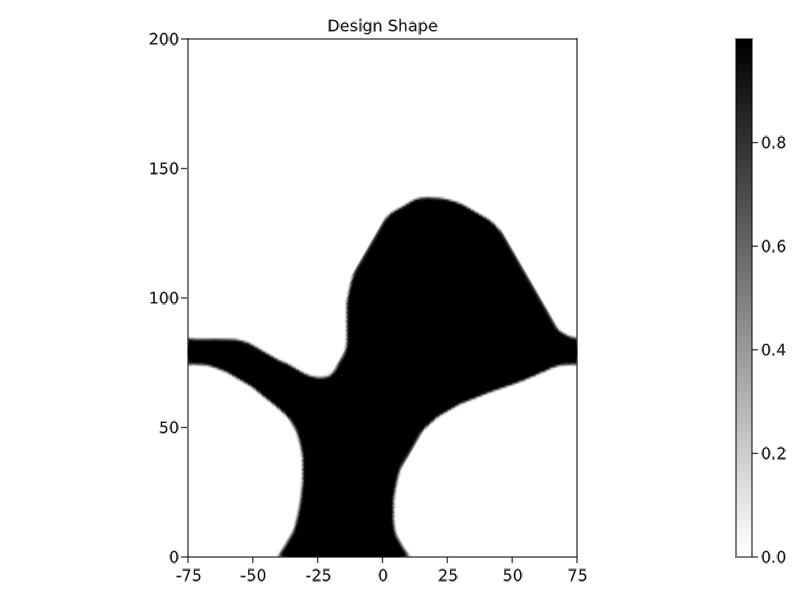

In [25]:
# Output and view
ImportFromFile = true
N = num_free_dofs(gridap.FE_U)
if ImportFromFile
    #p_max = readdlm("cloud/task5/p_opt_value.txt", Float64)
    p_max = readdlm("p_opt_value.txt", Float64)
    p0 = p_max[:]
else
    p0 = zeros(gridap.np)
end

kb = 0
pf_vec = pf_p0(p0; control, gridap)
pfh = FEFunction(gridap.FE_Pf, pf_vec)
pth = (pf -> Threshold(pf; control)) ∘ pfh
A1_mat = MatrixA(pth, kb; phys=phys1, control, gridap)
b1_vec = assemble_vector(v->(∫(v)gridap.dΓ_s), gridap.FE_V)
u1_vec = A1_mat \ b1_vec
u1h = FEFunction(gridap.FE_U, u1_vec)

A2_mat = MatrixA(pth, kb; phys=phys2, control, gridap)
o_vec = VectorO(1, 1; gridap)
v2_vec = A2_mat' \ o_vec
v2h = FEFunction(gridap.FE_U, v2_vec)

fig, ax, plt = plot(gridap.Ω, pth, colormap = :binary)
Colorbar(fig[1,2], plt)
ax.aspect = AxisAspect(L/(hd))
ax.title = "Design Shape"
limits!(ax, -L/2, L/2, 0, hd)
save("Results/shape.png", fig)
fig

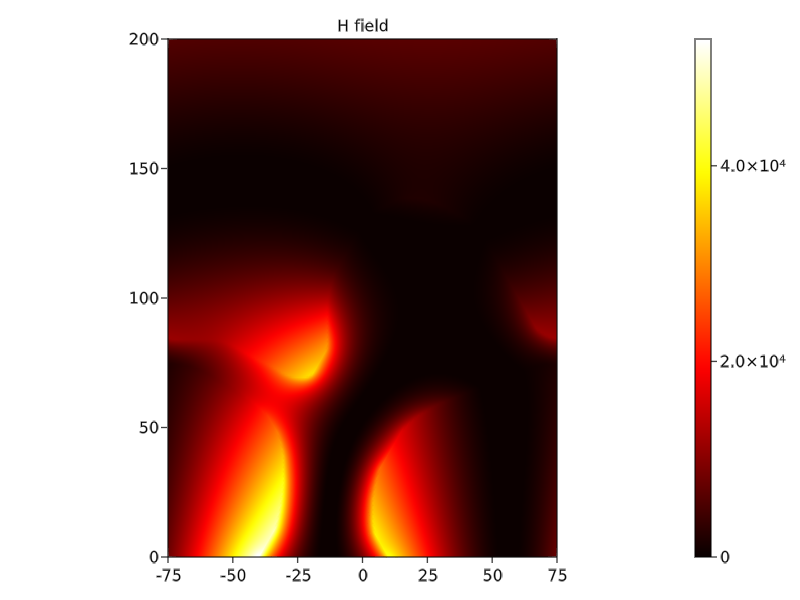

In [26]:
maxv = maximum(abs.(u1_vec))/1
#fig, ax, plt = plot(gridap.Ω, real(u1h), colormap = :bwr, colorrange=(-maxv, maxv))
fig, ax, plt = plot(gridap.Ω, abs2(u1h), colormap = :hot, colorrange=(0, maxv^2/1))
Colorbar(fig[1,2], plt)
ax.title = "H field"
ax.aspect = AxisAspect((L)/(hd))
#ax.aspect = AxisAspect(L/(h1))
limits!(ax, -L/2, L/2, 0, hd)
fig

In [16]:
p0 = rand(gridap.np)
δp = rand(gridap.np)*1e-8
grad = zeros(gridap.np)

kb = 0.0 * ω1
g0 = ge_p(p0, grad; kb, phys2, control, gridap)
g1 = ge_p(p0+δp, []; kb, phys2, control, gridap)
g1-g0, grad'*δp

(0.002440122203552164, 0.0024401222065483993)

In [ ]:
(0.0022638221489614807, 0.003159433513573705)